In [94]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
from tqdm.notebook import tqdm
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Fix a problem with easyocr, the kernel dies without this line
import easyocr
import cv2
import numpy as np
import fasttext
import torchvision
from models.models import *
from utils.utils import *
import pickle


### Preparing models and embedding

In [95]:
path_fasttext = r"C:\Users\Joan\Desktop\Deep_Learning_project\dlnn-project_ia-group_15\cc.en.300.bin"
path_model = r"C:\Users\Joan\Desktop\Deep_Learning_project\fasttext.pkl"

#### Loading the model

In [96]:
with open(path_model, 'rb') as f:
    data_model = pickle.load(f)
state_dict = data_model['model_weights']
config = data_model['parameters']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Transformer(num_classes=config["classes"], depth_transformer=config["depth"], heads_transformer=config["heads"], dim_fc_transformer=config["fc_transformer"]).to(device)
model.load_state_dict(state_dict)
model.eval()

Transformer(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm(

##### Reference for the labels

In [97]:
label2class = {1: "Bakery",
10:"Dry Cleaner",
11:"Funeral",
12:"Hotspot",
13:"MassageCenter",
14:"MedicalCenter",
15:"PackingStore",
16:"Pawnshop",
17:"PetShop",
18:"Pharmacy",
19:"Pizzeria",
2:"Barber",
20:"RepairShop",
21:"Restaurant",
22:"School",
23:"SteakHouse",
24:"Tavern",
25:"TeaHouse",
26:"Theatre",
27:"Tobacco",
28:"Motel",
3:"Bistro",
4:"Bookstore",
5:"Cafe",
6:"ComputerStore",
7:"CountryStore",
8:"Diner",
9:"DiscounHouse"}

#### Transformations aplied to images passed

In [98]:
input_size = 224
imgs_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(236, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
            torchvision.transforms.CenterCrop(input_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#### Inizializing word embedding and easy ocr 

In [99]:
w2v = fasttext.load_model(path_fasttext)
detector = easyocr.Reader(['en'])

### Predicting images

In [115]:
def extract_text_vectors_image(ocr_detector, emb, image, max_n_words=40, dim_w2v=300):
    image = cv2.GaussianBlur(image, (3,3), 0)
    text_detected = ocr_detector.readtext(image)
    list_text = [token[1] for token in text_detected]
    words = np.zeros((max_n_words, dim_w2v))
    text_mask = np.ones((max_n_words,), dtype=bool)
    i = 0
    for word in list(set(list_text)):
        if len(word) > 2:
            # if (word.lower() in vocab) and (i < max_n_words): # Comented when using fasttext
                # words[i,:] = emb[word.lower()] # Comented when using fasttext
            if i < max_n_words: # Comented when using glove
                words[i,:] = emb.get_word_vector(word.lower())  # Comented when using glove
                text_mask[i] = False
                i += 1
    return words, text_mask

In [124]:
def predict_image_class(model, emb, ocr_detector, image_path, label2class):
    img_rgb =  cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    words, text_mask = extract_text_vectors_image(ocr_detector, emb, img_rgb, max_n_words=40, dim_w2v=300)
    im_pil = Image.fromarray(img_rgb)
    img = imgs_transform(im_pil)
    img = img.unsqueeze(0).to(device)
    words = torch.tensor(words).float().unsqueeze(0).to(device)
    text_mask = torch.tensor(text_mask).bool().unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img, words, text_mask).cpu()
    probabilities = torch.softmax(output, dim=1)
    prob, pred = torch.max(probabilities, 1)

    prob = prob.to("cpu").numpy()[0]
    prob = round(prob*100, 1)
    plt.title("Predicted: "+ str(label2class[int(pred.to("cpu").numpy())+1]) + " (" + str(prob) + ")", color="black")

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    return probabilities

In [132]:
def top_3_classes(probabilities, label2class):
    data_probabilities_and_class = (torch.topk(probabilities, 3))
    probs = data_probabilities_and_class[0].numpy()[0]
    probs = [round(prob*100, 1) for prob in probs]
    classes = data_probabilities_and_class[1].numpy()[0]
    classes = [label2class[int(classe)+1] for classe in classes]

    for classe, prob in zip(classes, probs):
        print(classe, prob)


In [136]:
image_path = r"C:\Users\Joan\Desktop\Deep_Learning_project\20230525_184921.jpg"

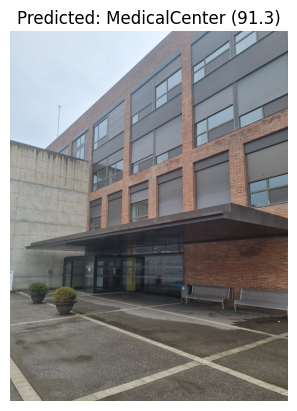

MedicalCenter 91.3
School 8.1
Funeral 0.1


In [137]:
probabilities = predict_image_class(model, w2v, detector, image_path, label2class)
top_3_classes(probabilities, label2class)